In [1]:
import pandas as pd
import numpy as np
import sys
import os
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
# Getting src path to import modules
src_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'src'))

# Adding src path to the system path, if not already added
if src_path not in sys.path:
    sys.path.append(src_path)

from dl_models import AutoencoderRefined as aer

In [2]:
# Time series data for a specific building (Building_1.csv/Building_2.csv/Building_3.csv).
electricity_data = pd.read_csv("../data/citylearn_challenge_2023_phase_1/Building_1.csv")

# Carbon intensity data.
carbon_data = pd.read_csv("../data/citylearn_challenge_2023_phase_1/carbon_intensity.csv")

# Pricing data.
pricing_data = pd.read_csv("../data/citylearn_challenge_2023_phase_1/pricing.csv")

# Weather data.
weather_data = pd.read_csv("../data/citylearn_challenge_2023_phase_1/weather.csv")

# Concatenate multiple datasets along the columns to create a single dataset.
df = pd.concat([electricity_data, carbon_data, pricing_data, weather_data], axis=1)

In [3]:
## Time series data for all buildings
building_1_data = pd.read_csv("../data/citylearn_challenge_2023_phase_1/Building_1.csv")
building_2_data = pd.read_csv("../data/citylearn_challenge_2023_phase_1/Building_2.csv")
building_3_data = pd.read_csv("../data/citylearn_challenge_2023_phase_1/Building_3.csv")

# Concatenate train and test data
train_df = pd.concat([building_1_data, carbon_data, pricing_data, weather_data], axis=1)

# Concatenate the data from Building 2 and Building 3 vertically, creating a unified dataset for evaluation
building_2_3_data = pd.concat([building_2_data, building_3_data], axis=0, ignore_index=True)

# Combine carbon intensity, pricing, and weather data horizontally to align with building data
external_data = pd.concat([carbon_data, pricing_data, weather_data], axis=1)

# Repeat the external data (carbon, pricing, weather) to match the number of rows in Building 2 and 3 data
external_data_repeated = pd.concat([external_data] * 2, axis=0, ignore_index=True)

# Combine the building data and the repeated external data horizontally, preparing the final test dataset
test_df = pd.concat([building_2_3_data, external_data_repeated], axis=1)

In [4]:
# Target features to forecast
targets = ['cooling_demand', 'carbon_intensity', 'solar_generation']

# List of features used for training the autoencoder.
features = ['month', 'hour', 'day_type', 'daylight_savings_status', 'indoor_dry_bulb_temperature', 'average_unmet_cooling_setpoint_difference', 
            'indoor_relative_humidity', 'non_shiftable_load', 'dhw_demand', 'cooling_demand', 'heating_demand', 'solar_generation', 'occupant_count', 
            'indoor_dry_bulb_temperature_set_point', 'hvac_mode', 'carbon_intensity', 'electricity_pricing', 
            'electricity_pricing_predicted_6h', 'electricity_pricing_predicted_12h', 'electricity_pricing_predicted_24h', 
            'outdoor_dry_bulb_temperature', 'outdoor_relative_humidity', 'diffuse_solar_irradiance', 'direct_solar_irradiance', 
            'outdoor_dry_bulb_temperature_predicted_6h', 'outdoor_dry_bulb_temperature_predicted_12h', 'outdoor_dry_bulb_temperature_predicted_24h', 
            'outdoor_relative_humidity_predicted_6h', 'outdoor_relative_humidity_predicted_12h', 'outdoor_relative_humidity_predicted_24h', 
            'diffuse_solar_irradiance_predicted_6h', 'diffuse_solar_irradiance_predicted_12h', 'diffuse_solar_irradiance_predicted_24h', 
            'direct_solar_irradiance_predicted_6h', 'direct_solar_irradiance_predicted_12h', 'direct_solar_irradiance_predicted_24h']

In [5]:
def plot_all_target_comparisons(real, pred, targets, features, n_cols=2, figsize=(10, 10), percent=False):
    n_targets = len(targets)
    n_rows = int(np.ceil(n_targets / n_cols))

    fig, axs = plt.subplots(n_rows, n_cols, figsize=figsize)
    axs = axs.flatten() if n_targets > 1 else [axs]

    for i, target in enumerate(targets):
        ax = axs[i]
        target_index = features.index(target)

        real_target = real[:, target_index]
        pred_target = pred[:, target_index]

        mae = np.abs(real_target - pred_target).mean()
        nmae = mae / (real_target.max() - real_target.min())
        nmse = ((real_target - pred_target) ** 2).mean() / np.var(real_target)
        nrmse = np.sqrt(((real_target - pred_target) ** 2).mean()) / (real_target.max() - real_target.min())

        if percent:
            nmae *= 100
            nmse *= 100
            nrmse *= 100
        
        ax.scatter(real_target, pred_target, alpha=0.6,
                   s=15, c=np.abs(real_target - pred_target), cmap='Spectral',
                   edgecolors='black',  linewidth=0.5,
                   label=f"NMAE={nmae:.3f}%\nNMSE={nmse:.3f}%\nNRMSE={nrmse:.3f}%")
        ax.plot([real_target.min(), real_target.max()],
                [real_target.min(), real_target.max()],
                'k-', linewidth=1)
        ax.set_title(f"Target: {target}")
        ax.set_xlabel("True")
        ax.set_ylabel("Predicted")
        ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
        ax.legend()

    for j in range(i + 1, len(axs)):
        fig.delaxes(axs[j])

    plt.tight_layout()
    plt.show()

In [6]:
real_6, pred_6 = aer.Autoencoder(train_df=train_df, test_df=test_df, features=features, epochs = 3000, latent_dim = 32, batch_size = 128)

Epoch 1/3000
6/6 [==============================] - 1s 7ms/step - loss: 0.0825
Epoch 2/3000
6/6 [==============================] - 0s 6ms/step - loss: 0.0395
Epoch 3/3000
6/6 [==============================] - 0s 5ms/step - loss: 0.0282
Epoch 4/3000
6/6 [==============================] - 0s 5ms/step - loss: 0.0223
Epoch 5/3000
6/6 [==============================] - 0s 5ms/step - loss: 0.0177
Epoch 6/3000
6/6 [==============================] - 0s 5ms/step - loss: 0.0144
Epoch 7/3000
6/6 [==============================] - 0s 5ms/step - loss: 0.0123
Epoch 8/3000
6/6 [==============================] - 0s 5ms/step - loss: 0.0109
Epoch 9/3000
6/6 [==============================] - 0s 5ms/step - loss: 0.0101
Epoch 10/3000
6/6 [==============================] - 0s 6ms/step - loss: 0.0093
Epoch 11/3000
6/6 [==============================] - 0s 5ms/step - loss: 0.0085
Epoch 12/3000
6/6 [==============================] - 0s 5ms/step - loss: 0.0078
Epoch 13/3000
6/6 [==============================

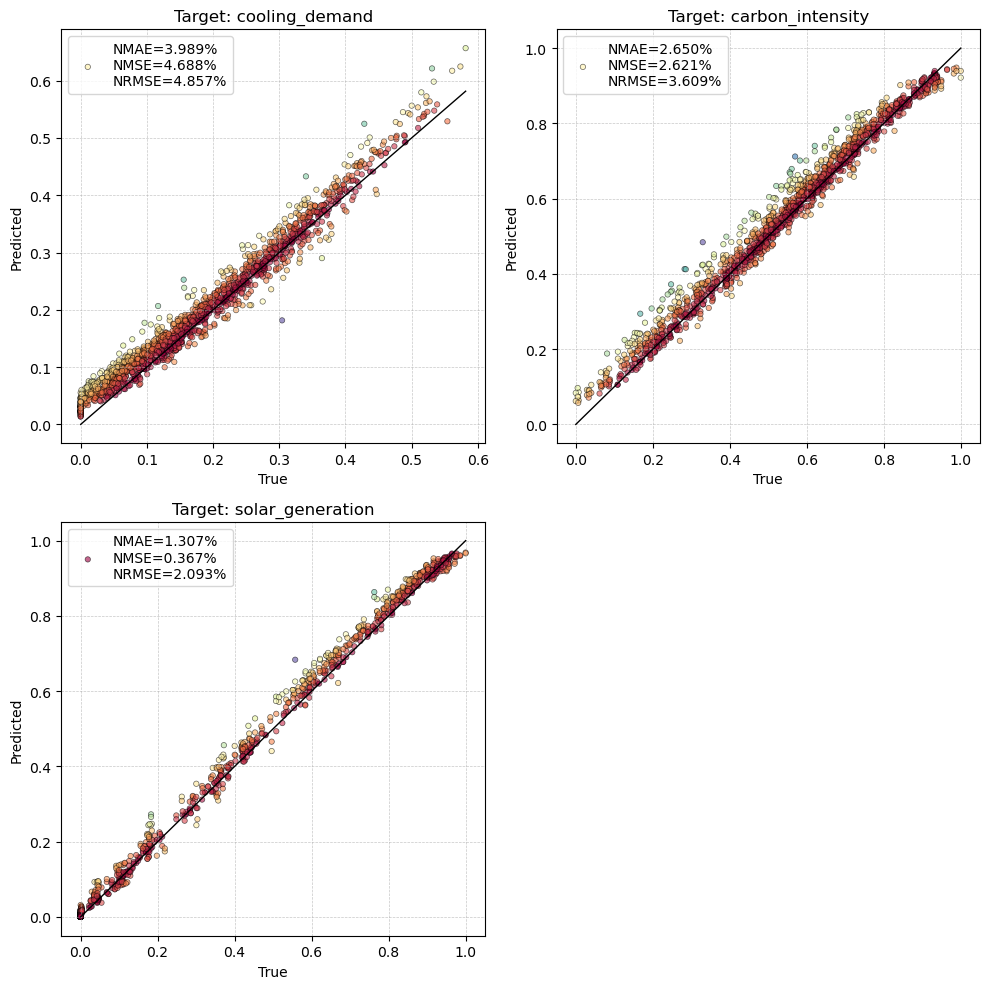

In [7]:
plot_all_target_comparisons(real_6, pred_6, targets, features, percent=True)

BEST AER -> 512/256/128 | 128/256/512, activation = elu, optimizer = adam(0.00007), epochs = 3000, latent_dim = 32, batch_size = 128